In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Data pre-processing

Machine-learning algorithms are based on optimization or statistical frameworks. These frameworks relies on numerical data and make some assumprions on the data themselves. We will see two different transformations which are commonly used before to apply machine-learning algorithms: (i) scaling and (ii) encoding. 

## Scaling numerical data

### Motivation

Let's illustrate the importance of scaling data before to fit a classifier.

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train , X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)
print('LogisticRegression trained with {} iterations with a loss equal to {}'
      .format(clf.n_iter_, clf.tol))

LogisticRegression trained with [80] iterations with a loss equal to 0.0001


In [3]:
X_train -= X_train.mean(axis=0)
X_train /= X_train.std(axis=0)
clf.fit(X_train, y_train)
print('LogisticRegression trained with {} iterations with a loss equal to {}'
      .format(clf.n_iter_, clf.tol))

LogisticRegression trained with [23] iterations with a loss equal to 0.0001


Algorithms based on optimization framework (gradient descent, etc.) make the assumption that the data are scaled. As a consequence, learning will be quicker and the problem will be better posed. We will dive into the scikit-learn scalers which will transform the data. 

### Scaler in scikit-learn

A very basic example is the rescaling of our data, which is a requirement for many machine learning algorithms as they are not scale-invariant -- rescaling falls into the category of data pre-processing and can barely be called *learning*. There exist many different rescaling technques, and in the following example, we will take a look at a particular method that is commonly called "standardization." Here, we will recale the data so that each feature is centered at zero (mean = 0) with unit variance (standard deviation = 0).

For example, if we have a 1D dataset with the values [1, 2, 3, 4, 5], the standardized values are

- 1 -> -1.41
- 2 -> -0.71
- 3 -> 0.0
- 4 -> 0.71
- 5 -> 1.41

computed via the equation $x_{standardized} = \frac{x - \mu_x}{\sigma_x}$,
where $\mu$ is the sample mean, and $\sigma$ the standard deviation, respectively.

In [4]:
ary = np.array([1, 2, 3, 4, 5])
ary_standardized = (ary - ary.mean()) / ary.std()
ary_standardized

array([-1.41421356, -0.70710678,  0.        ,  0.70710678,  1.41421356])

Although standardization is a most basic preprocessing procedure -- as we've seen in the code snipped above -- scikit-learn implements a `StandardScaler` class for this computation. And in later sections, we will see why and when the scikit-learn interface comes in handy over the code snippet we executed above.  

Applying such a preprocessing has a very similar interface to the supervised learning algorithms we saw so far.
To get some more practice with scikit-learn's "Transformer" interface, let's start by loading the iris dataset and rescale it:


In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0, stratify=y
)
print(X_train.shape)
print(X_test.shape)

(112, 4)
(38, 4)


The iris dataset is not "centered" that is it has non-zero mean and the standard deviation is different for each component:


In [8]:
print("mean : %s " % X_train.mean(axis=0))
print("standard deviation : %s " % X_train.std(axis=0))

mean : [5.86607143 3.03928571 3.77053571 1.20982143] 
standard deviation : [0.85664978 0.45185276 1.78583906 0.76063411] 


To use a preprocessing method, we first import the estimator, here StandardScaler and instantiate it:
    

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

As with the classification and regression algorithms, we call ``fit`` to learn the model from the data. As this is an unsupervised model, we only pass ``X``, not ``y``. This simply estimates mean and standard deviation.

In [10]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
#scaler.scale_

array([0.85664978, 0.45185276, 1.78583906, 0.76063411])

Now we can rescale our data by applying the ``transform`` (not ``predict``) method:

In [15]:
X_train_scaled = scaler.transform(X_train)

``X_train_scaled`` has the same number of samples and features, but the mean was subtracted and all features were scaled to have unit standard deviation:

In [16]:
print(X_train_scaled.shape)

(112, 4)


In [17]:
print("mean : %s " % X_train_scaled.mean(axis=0))
print("standard deviation : %s " % X_train_scaled.std(axis=0))

mean : [-1.29955570e-15  1.27080885e-15  4.97617820e-16 -6.74063979e-17] 
standard deviation : [1. 1. 1. 1.] 


To summarize: Via the `fit` method, the estimator is fitted to the data we provide. In this step, the estimator estimates the parameters from the data (here: mean and standard deviation). Then, if we `transform` data, these parameters are used to transform a dataset. (Please note that the transform method does not update these parameters).

It's important to note that the same transformation is applied to the training and the test set. That has the consequence that usually the mean of the test data is not zero after scaling:

In [18]:
X_test_scaled = scaler.transform(X_test)
print("mean test data: %s" % X_test_scaled.mean(axis=0))

mean test data: [-0.10477518  0.15766331 -0.02770859 -0.05442877]


It is important for the training and test data to be transformed in exactly the same way, for the following processing steps to make sense of the data, as is illustrated in the figure below:

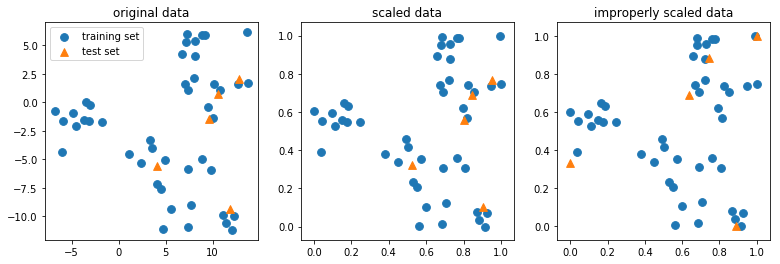

In [19]:
from figures import plot_relative_scaling
plot_relative_scaling()

There are several common ways to scale the data. The most common one is the ``StandardScaler`` we just introduced, but rescaling the data to a fix minimum an maximum value with ``MinMaxScaler`` (usually between 0 and 1), or using more robust statistics like median and quantile, instead of mean and standard deviation (with ``RobustScaler``), are also useful.

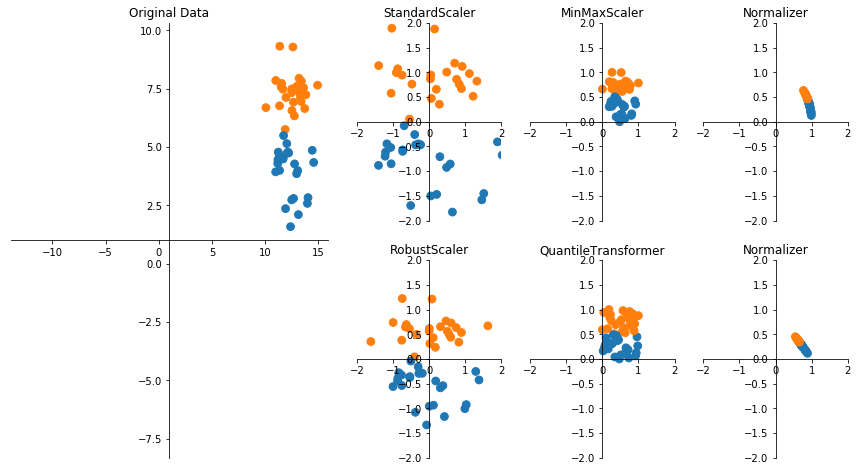

In [26]:
from figures import plot_scaling
plot_scaling()

## Encoding categorical data

In the previous section, we saw how important it was to normalize numerical data. In data science, another type of data are usually encountered: categorical data. These type of data can be grouped in a finite group of categories.

In previous example, we presented the iris dataset. We could imagine an additional feature which could be the color of the flower. The color would be defined by a finite set of known values (purple, blue, yellow, etc.) which will form the categories.

Categorical data can be expressed sometimes as strings. Machine-learning algorithms are premilarly working with numerical data. Thus, it might not work as expected. We can check an example.

We will add an additional column by giving a random color to each sample in the iris dataset.

In [27]:
X_train[:10]

array([['5.0', '2.0', '3.5', '1.0', 'blue', 'blue'],
       ['4.9', '3.0', '1.4', '0.2', 'purple', 'purple'],
       ['4.4', '2.9', '1.4', '0.2', 'purple', 'purple'],
       ['5.0', '2.3', '3.3', '1.0', 'yellow', 'yellow'],
       ['4.9', '2.5', '4.5', '1.7', 'yellow', 'yellow'],
       ['6.3', '2.5', '5.0', '1.9', 'yellow', 'yellow'],
       ['6.3', '2.3', '4.4', '1.3', 'yellow', 'yellow'],
       ['5.0', '3.5', '1.3', '0.3', 'yellow', 'yellow'],
       ['6.1', '2.8', '4.7', '1.2', 'purple', 'purple'],
       ['5.0', '3.5', '1.6', '0.6', 'yellow', 'yellow']], dtype='<U32')

In [28]:
color_feature = np.random.choice(
    ['purple', 'yellow', 'blue'], size=X_train.shape[0]
)
color_feature

array(['yellow', 'purple', 'blue', 'yellow', 'blue', 'purple', 'blue',
       'yellow', 'purple', 'yellow', 'blue', 'blue', 'blue', 'blue',
       'yellow', 'purple', 'yellow', 'purple', 'yellow', 'blue', 'yellow',
       'yellow', 'purple', 'purple', 'blue', 'blue', 'yellow', 'purple',
       'purple', 'yellow', 'yellow', 'purple', 'purple', 'yellow', 'blue',
       'purple', 'blue', 'yellow', 'blue', 'purple', 'blue', 'purple',
       'purple', 'blue', 'yellow', 'purple', 'yellow', 'blue', 'yellow',
       'yellow', 'purple', 'blue', 'blue', 'purple', 'blue', 'blue',
       'yellow', 'purple', 'blue', 'purple', 'blue', 'purple', 'blue',
       'blue', 'blue', 'yellow', 'yellow', 'purple', 'blue', 'blue',
       'purple', 'blue', 'yellow', 'purple', 'yellow', 'yellow', 'blue',
       'yellow', 'blue', 'purple', 'yellow', 'purple', 'purple', 'yellow',
       'blue', 'purple', 'purple', 'yellow', 'blue', 'blue', 'yellow',
       'yellow', 'purple', 'blue', 'blue', 'blue', 'blue', 'yello

In [33]:
X_train = np.hstack([X_train, color_feature[:, np.newaxis]])

In [31]:
X_train[:10]

array([['5.0', '2.0', '3.5', '1.0', 'blue', 'blue', 'yellow', 'yellow'],
       ['4.9', '3.0', '1.4', '0.2', 'purple', 'purple', 'purple',
        'purple'],
       ['4.4', '2.9', '1.4', '0.2', 'purple', 'purple', 'blue', 'blue'],
       ['5.0', '2.3', '3.3', '1.0', 'yellow', 'yellow', 'yellow',
        'yellow'],
       ['4.9', '2.5', '4.5', '1.7', 'yellow', 'yellow', 'blue', 'blue'],
       ['6.3', '2.5', '5.0', '1.9', 'yellow', 'yellow', 'purple',
        'purple'],
       ['6.3', '2.3', '4.4', '1.3', 'yellow', 'yellow', 'blue', 'blue'],
       ['5.0', '3.5', '1.3', '0.3', 'yellow', 'yellow', 'yellow',
        'yellow'],
       ['6.1', '2.8', '4.7', '1.2', 'purple', 'purple', 'purple',
        'purple'],
       ['5.0', '3.5', '1.6', '0.6', 'yellow', 'yellow', 'yellow',
        'yellow']], dtype='<U32')

In [32]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/home/thomas/anaconda3/envs/python-workshop/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'blue'

Then, we need to convert the string categories into numerical data. We will present two strategies which are currently available in scikit-learn to tackle this issue.

### One-hot encoder

The most common way to deal with categorical data is to one-hot encode the categories. Each categorie of the original feature will be represented as a column and for each sample, `1` will be affected to the corresponding category while others will be given `0`. We can illustrate this on our toy example.

In [34]:
color_feature = np.random.choice(
    ['purple', 'yellow', 'blue'], size=X_train.shape[0]
).astype(object)
color_feature = color_feature[:, np.newaxis]
color_feature[:10]

array([['purple'],
       ['purple'],
       ['purple'],
       ['blue'],
       ['purple'],
       ['purple'],
       ['blue'],
       ['blue'],
       ['blue'],
       ['purple']], dtype=object)

In [35]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

In [36]:
color_feature_encoded = ohe.fit_transform(color_feature)
color_feature_encoded[:10]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [37]:
ohe.categories_

[array(['blue', 'purple', 'yellow'], dtype=object)]

### Ordinal encoder

In the previous example, we might have been tempted to assign numbers to these features instead of string, i.e. *purple=1, blue=2, yellow=3* but in general **this is a bad idea**.
Estimators tend to operate under the assumption that numerical features lie on some continuous scale, so, for example, 1 and 2 are more alike than 1 and 3, and this is often not the case for categorical features.

An example of ordinal features would be T-shirt sizes, e.g., XL > L > M > S.

Let's imagine the same type of categories for our flowers.

In [38]:
flower_size = np.random.choice(
    ['S', 'M', 'L', 'XL'], size=X_train.shape[0]
).astype(object)
flower_size = flower_size[:, np.newaxis]
flower_size[:10]

array([['S'],
       ['M'],
       ['XL'],
       ['S'],
       ['XL'],
       ['M'],
       ['M'],
       ['XL'],
       ['S'],
       ['L']], dtype=object)

In [42]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()

In [40]:
flower_size_encoded = oe.fit_transform(flower_size)
flower_size_encoded[:10]

array([[2.],
       [1.],
       [3.],
       [2.],
       [3.],
       [1.],
       [1.],
       [3.],
       [2.],
       [0.]])

In [41]:
oe.categories_

[array(['L', 'M', 'S', 'XL'], dtype=object)]

## Exercise

* Read the titanic dataset located in `datasets/titanic3.csv` using Pandas. Select the following columns: `['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']`

In [46]:
import pandas as pd
df = pd.read_csv("datasets/titanic3.csv")
df = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
df

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S
5,1,male,48.0000,0,0,26.5500,S
6,1,female,63.0000,1,0,77.9583,S
7,1,male,39.0000,0,0,0.0000,S
8,1,female,53.0000,2,0,51.4792,S
9,1,male,71.0000,0,0,49.5042,C


In [57]:
# %load solutions/preprocessing_01.py
import os
import pandas as pd

titanic = pd.read_csv(os.path.join('datasets', 'titanic3.csv'))
titanic = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
titanic.head()


,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S


In [50]:
titanic.shape

(1309, 7)

* Remove the rows containing NaN using `pd.DataFrame.dropna`.

In [58]:
titanic = titanic.dropna()
titanic

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S
5,1,male,48.0000,0,0,26.5500,S
6,1,female,63.0000,1,0,77.9583,S
7,1,male,39.0000,0,0,0.0000,S
8,1,female,53.0000,2,0,51.4792,S
9,1,male,71.0000,0,0,49.5042,C


In [59]:
# %load solutions/preprocessing_02.py
titanic = titanic.dropna()
titanic.shape


(1043, 7)

* Separate the data into numerical and categorical data into two dataframes.

In [87]:
titanic.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S


In [66]:
titanic.describe()

,pclass,age,sibsp,parch,fare
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,2.209012,29.813199,0.504314,0.421860,36.603024
std,0.840685,14.366261,0.913080,0.840655,55.753648
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,8.050000
50%,2.000000,28.000000,0.000000,0.000000,15.750000
75%,3.000000,39.000000,1.000000,1.000000,35.077100
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [77]:
# %load solutions/preprocessing_03.py
categorical_columns = ['pclass', 'sex', 'embarked']
numerical_columns = ['age', 'sibsp', 'parch', 'fare']

categorical_titanic = titanic[categorical_columns]
numerical_titanic = titanic[numerical_columns]

In [78]:
categorical_titanic

,pclass,sex,embarked
0,1,female,S
1,1,male,S
2,1,female,S
3,1,male,S
4,1,female,S
5,1,male,S
6,1,female,S
7,1,male,S
8,1,female,S
9,1,male,C


In [79]:
numerical_titanic

,age,sibsp,parch,fare
0,29.0000,0,0,211.3375
1,0.9167,1,2,151.5500
2,2.0000,1,2,151.5500
3,30.0000,1,2,151.5500
4,25.0000,1,2,151.5500
5,48.0000,0,0,26.5500
6,63.0000,1,0,77.9583
7,39.0000,0,0,0.0000
8,53.0000,2,0,51.4792
9,71.0000,0,0,49.5042


* Standardized the numerical dataframe and one-hot encode the categorical dataframe.

In [71]:
# %load solutions/preprocessing_04.py
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_encoded = OneHotEncoder(sparse=False).fit_transform(categorical_titanic)
num_normalized = StandardScaler().fit_transform(numerical_titanic)


/home/thomas/anaconda3/envs/python-workshop/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thomas/anaconda3/envs/python-workshop/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [80]:
cat_encoded

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [81]:
num_normalized

array([[-0.05663194, -0.55258747, -0.50206398,  3.13554913],
       [-2.01237899,  0.54313255,  1.87817569,  2.06268333],
       [-1.93693697,  0.54313255,  1.87817569,  2.06268333],
       ...,
       [-0.23073426, -0.55258747, -0.50206398, -0.52717838],
       [-0.1959138 , -0.55258747, -0.50206398, -0.52717838],
       [-0.05663194, -0.55258747, -0.50206398, -0.51551435]])

* Concatenate the encoded arrays using `np.concatenate`.

In [75]:
# %load solutions/preprocessing_05.py
full_data = np.concatenate([cat_encoded, num_normalized], axis=1)
full_data.shape

(1043, 12)

In [76]:
full_data

array([[ 1.        ,  0.        ,  0.        , ..., -0.55258747,
        -0.50206398,  3.13554913],
       [ 1.        ,  0.        ,  0.        , ...,  0.54313255,
         1.87817569,  2.06268333],
       [ 1.        ,  0.        ,  0.        , ...,  0.54313255,
         1.87817569,  2.06268333],
       ...,
       [ 0.        ,  0.        ,  1.        , ..., -0.55258747,
        -0.50206398, -0.52717838],
       [ 0.        ,  0.        ,  1.        , ..., -0.55258747,
        -0.50206398, -0.52717838],
       [ 0.        ,  0.        ,  1.        , ..., -0.55258747,
        -0.50206398, -0.51551435]])

## The `ColumnTransformer` to simplify this pattern

You can imagine that encoding categorical columns and standardizing the numerical ones is a very generic pattern. Scikit-learn provides the `ColumnTransformer` (and the `make_column_transformer` to simplify such processing by assigning a transformer to a specific set of columns and concatenate the results.

In [82]:
import os
import pandas as pd

titanic = pd.read_csv(os.path.join('datasets', 'titanic3.csv'))
titanic = titanic[['pclass', 'sex', 'age', 'sibsp',
                   'parch', 'fare', 'embarked']].dropna()
titanic.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S


In [83]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_columns = ['pclass', 'sex', 'embarked']
numerical_columns = ['age', 'sibsp', 'parch', 'fare']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (StandardScaler(), numerical_columns)
)
X_encoded = preprocessor.fit_transform(titanic)

/home/thomas/anaconda3/envs/python-workshop/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thomas/anaconda3/envs/python-workshop/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [84]:
X_encoded.shape

(1043, 12)

### Exercise

Load the adult dataset located in `./datasets/adult_openml.csv`. Make your own `ColumnTransformer` preprocessor. Let's do step by step with the following instructions.

* Read the adult dataset located in `datasets/adult_openml.csv` using `pd.read_csv`.
* Split the datasets into a data and a target. The target corresponds to the `class` column. For the data, drop the columns `fnlwgt`, `capitalgain`, and `capitalloss`.
* Create a list containing the name of the categorical columns. Similarly, do the same for the numerical data.
* Create a pipeline to one-hot encode the categorical data. Use the `KBinsDiscretizer` for the numerical data. Import it from `sklearn.preprocessing`.
* Create a `preprocessor` by using the `make_column_transformer`. You should apply the good pipeline to the good column.
* Apply `fit_transform` to obtain preprocessed data.

In [92]:
import pandas as pd
df = pd.read_csv("datasets/adult_openml.csv")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [95]:
data = df.drop(columns=['class', 'fnlwgt', 'capitalgain', 'capitalloss'])
target = df['class']
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hoursperweek,native-country
0,2,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2,United-States
1,3,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,United-States
2,2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,2,United-States
3,3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,2,United-States
4,1,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,2,Cuba


In [97]:
col_cat = ['workclass', 'education', 'marital-status', 'occupation',
           'relationship', 'race', 'native-country', 'sex']
col_num = ['age', 'hoursperweek']

In [99]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (OneHotEncoder(), col_cat),
    (KBinsDiscretizer(), col_num)
)

In [100]:
X_encoded = preprocessor.fit_transform(X)
X_encoded[:10]

<10x112 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [101]:
# %load solutions/preprocessing_06.py
import os
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import make_column_transformer

adult = pd.read_csv(os.path.join('datasets', 'adult_openml.csv'))

y = adult['class']
X = adult.drop(columns=['class', 'fnlwgt', 'capitalgain', 'capitalloss'])

col_cat = ['workclass', 'education', 'marital-status', 'occupation',
           'relationship', 'race', 'native-country', 'sex']
col_num = ['age', 'hoursperweek']

pipe_cat = OneHotEncoder(handle_unknown='ignore')
pipe_num = KBinsDiscretizer()

preprocessor = make_column_transformer(
    (col_cat, pipe_cat, ), (col_num, pipe_num)
)

X_encoded = preprocessor.fit_transform(X)
print(X_encoded[:10])


/home/thomas/anaconda3/envs/python-workshop/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:739: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


  (0, 7)	1.0
  (0, 18)	1.0
  (0, 29)	1.0
  (0, 33)	1.0
  (0, 48)	1.0
  (0, 57)	1.0
  (0, 97)	1.0
  (0, 101)	1.0
  (0, 105)	1.0
  (0, 110)	1.0
  (1, 6)	1.0
  (1, 18)	1.0
  (1, 27)	1.0
  (1, 36)	1.0
  (1, 47)	1.0
  (1, 57)	1.0
  (1, 97)	1.0
  (1, 101)	1.0
  (1, 106)	1.0
  (1, 107)	1.0
  (2, 4)	1.0
  (2, 20)	1.0
  (2, 25)	1.0
  (2, 38)	1.0
  (2, 48)	1.0
  :	:
  (7, 57)	1.0
  (7, 97)	1.0
  (7, 101)	1.0
  (7, 106)	1.0
  (7, 110)	1.0
  (8, 4)	1.0
  (8, 21)	1.0
  (8, 29)	1.0
  (8, 42)	1.0
  (8, 48)	1.0
  (8, 57)	1.0
  (8, 97)	1.0
  (8, 100)	1.0
  (8, 104)	1.0
  (8, 111)	1.0
  (9, 4)	1.0
  (9, 18)	1.0
  (9, 27)	1.0
  (9, 36)	1.0
  (9, 47)	1.0
  (9, 57)	1.0
  (9, 97)	1.0
  (9, 101)	1.0
  (9, 105)	1.0
  (9, 110)	1.0
